# 5. Data Split & Modelltraining

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
import pickle

Dies Funktion gibt eine grafische Repräsentation der wichtigsten Features in einem Random Forest oder xgBoost Modell aus.

*Quelle: Blohm, 2022, Jyupter Notebook - TreesForestsEnsembles.ipynb*

In [2]:
def plot_variable_importance(model, X_train):
    imp=pd.DataFrame({"imp":model.best_estimator_.feature_importances_, "names":X_train.columns}).sort_values("imp", ascending=True)
    fig, ax = plt.subplots(figsize=(imp.shape[0]/6,imp.shape[0]/5), dpi=300) 
    ax.barh(imp["names"],imp["imp"], color="green") 
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot\n') 
    plt.show()

Die zuvor gesäuberten Daten werden importiert:

In [3]:
data = pd.read_csv(
    'cleaned_data.csv',
    #index_col=0
    )
data

,BFS-Nr,Ladestationen,EV_Bestand_2021,Strassenlänge(km),Anz_Einwohner,Einwohner_Veränderung_2010-2019,Bevölkerungsdichte_pro_km2,Altersverteilung_0-19,Altersverteilung_20-64,Rohe_Geburtenziffer,...,Landwirtschaftsfläche,Wald&Gehölze,Beschäftigte_1_Sektor,Beschäftigte_2_Sektor,Beschäftigte_3_Sektor,Leerwohnungsziffer,Neu_gebaute_Wohnungen(pro_1000_Einwohner),Sozialhilfequote,CO2-Gesetz_Ja-Anteil,CO2-Gesetz_Stimmbeteiligung
0,1,1.0,39.0,26.516156,1981.0,8.607456,250.442478,19.787986,62.190813,9.084027,...,51.139241,30.886076,39.0,25.0,378.0,5.291577,13.910355,1.01,53.189401,72.073343
1,2,24.0,103.0,66.711839,12303.0,10.927779,1161.756374,20.165813,61.667886,12.881135,...,40.170940,28.205128,47.0,1307.0,5566.0,1.005548,3.787255,3.02,51.250000,58.204808
2,3,4.0,70.0,31.501571,5572.0,8.005427,749.932705,23.636037,59.834889,9.892086,...,55.510753,28.629032,34.0,111.0,869.0,1.171717,0.181422,1.51,55.077960,65.184175
3,4,0.0,45.0,42.495957,3751.0,11.636905,275.808824,22.180752,59.824047,8.588298,...,55.906090,28.833456,93.0,136.0,792.0,0.630011,3.002183,1.19,50.000000,68.894099
4,5,0.0,56.0,33.142703,3778.0,10.791789,578.560490,21.625199,61.646374,7.454739,...,46.341463,33.231707,29.0,679.0,770.0,0.962696,3.248511,1.47,54.629097,69.401506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,6806,1.0,3.0,19.431732,559.0,1.821494,61.092896,18.425760,56.887299,16.378526,...,55.846995,37.595628,31.0,182.0,28.0,2.749141,0.000000,1.67,30.303030,61.663286
2143,6807,0.0,9.0,46.657442,1238.0,-5.279265,53.732639,21.728595,52.988691,8.103728,...,44.043478,47.652174,149.0,186.0,139.0,2.155172,0.825083,2.11,32.206406,60.721868
2144,6808,0.0,9.0,101.283739,1263.0,0.158604,20.453441,18.289786,56.611243,12.553943,...,42.884896,52.096487,205.0,91.0,349.0,2.422145,1.534919,2.10,45.625000,58.754513
2145,6809,0.0,2.0,64.072282,1085.0,-6.060606,26.508673,17.788018,55.483871,9.174312,...,56.301905,39.618955,136.0,472.0,174.0,3.869048,4.528986,2.37,36.163522,64.015905


## 5.1 Data Split

In der Schweiz leben rund 84.8% der Bevölkerung in städtischen Gebieten. Als städtisch wird eine Gemeinde bezeichnet, die mehr als 10'000 Einwohner hat. Diese machen jedoch nur rund etwa 8% der schweizer Gemeinden aus. 

Um diese ungleichmässige Verteilung im Train-Test-Split zu berücksichtigen, wird jede Gemeinde basierend auf der Einwohnerzahl kategorisiert. Dabei werden drei Kategorien eingeführt: Grossstadt (>50'000 Einwohner), Stadt(>10'000 Einwohner) und ländliche Gemeinden (<10'000 Einwohner).

In [4]:
def is_city(Gemeinde):
    if Gemeinde['Anz_Einwohner'] >= 50000:
        return 2
    elif Gemeinde['Anz_Einwohner'] >= 10000:
        return 1
    else:
        return 0

data['Gemeinde_Kategorie'] = data.apply(is_city, axis=1)

In [5]:
data['Gemeinde_Kategorie'].describe()

count    2147.000000
mean        0.081043
std         0.289534
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Gemeinde_Kategorie, dtype: float64

In [6]:
data['Gemeinde_Kategorie'].value_counts()

0    1983
1     154
2      10
Name: Gemeinde_Kategorie, dtype: int64

Durch die Internet-Recherche hat sich ergeben, dass der Stratified Shuffle Split genau diese Anforderung erfüllt.

Quelle: https://www.geeksforgeeks.org/sklearn-stratifiedshufflesplit-function-in-python/

In [7]:
split = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)

for train_ind, test_ind in split.split(data, data['Gemeinde_Kategorie']):
    train = data.loc[train_ind]
    test = data.loc[test_ind]

In [8]:
train.set_index('BFS-Nr', inplace=True)
train['Gemeinde_Kategorie'].value_counts()/len(train['Gemeinde_Kategorie'])

0    0.923704
1    0.071637
2    0.004659
Name: Gemeinde_Kategorie, dtype: float64

In [9]:
test.set_index('BFS-Nr', inplace=True)
test['Gemeinde_Kategorie'].value_counts()/len(test['Gemeinde_Kategorie'])

0    0.923256
1    0.072093
2    0.004651
Name: Gemeinde_Kategorie, dtype: float64

Der Train- & Test-Split enthalten den selben Grossstadt-, Stadt- & Dorf-Anteil

In [10]:
X_train = train.drop('Ladestationen', axis=1)
y_train = train['Ladestationen']

X_test = test.drop('Ladestationen', axis=1)
y_test = test['Ladestationen']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1717, 23), (1717,), (430, 23), (430,))

## 5.2 Modellauswahl

Um einen kleinen Benchmark zu haben, wird die Performance von einem getuntem RandomForest mit getunedem XGBoost verglichen. Dabei wird der RMSE, maximale Fehlerwert, MAE und das Bestimmtheitsmass R2 verwendet.

### 4.2.1 RandomForest

In [11]:
parameters = {"n_estimators":range(0, 300, 10),
              "max_depth":range(0,30)}

In [12]:
forest_reg_RS = RandomizedSearchCV(RandomForestRegressor(random_state = 1), parameters, cv=5)

In [13]:
forest_reg_RS.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
                   param_distributions={'max_depth': range(0, 30),
                                        'n_estimators': range(0, 300, 10)})

In [14]:
forest_reg_RS.best_params_

{'n_estimators': 90, 'max_depth': 4}

In [15]:
y_pred_rf = forest_reg_RS.predict(X_test)

In [16]:
print('RMSE:', mean_squared_error(y_test, y_pred_rf, squared=False))
print('max. Error:', max_error(y_test, y_pred_rf))
print('MAE:', mean_absolute_error(y_test, y_pred_rf))
print('R2:', r2_score(y_test, y_pred_rf))

RMSE: 4.48884720683084
max. Error: 47.88451058201056
MAE: 2.302644937110866
R2: 0.7378817233039396


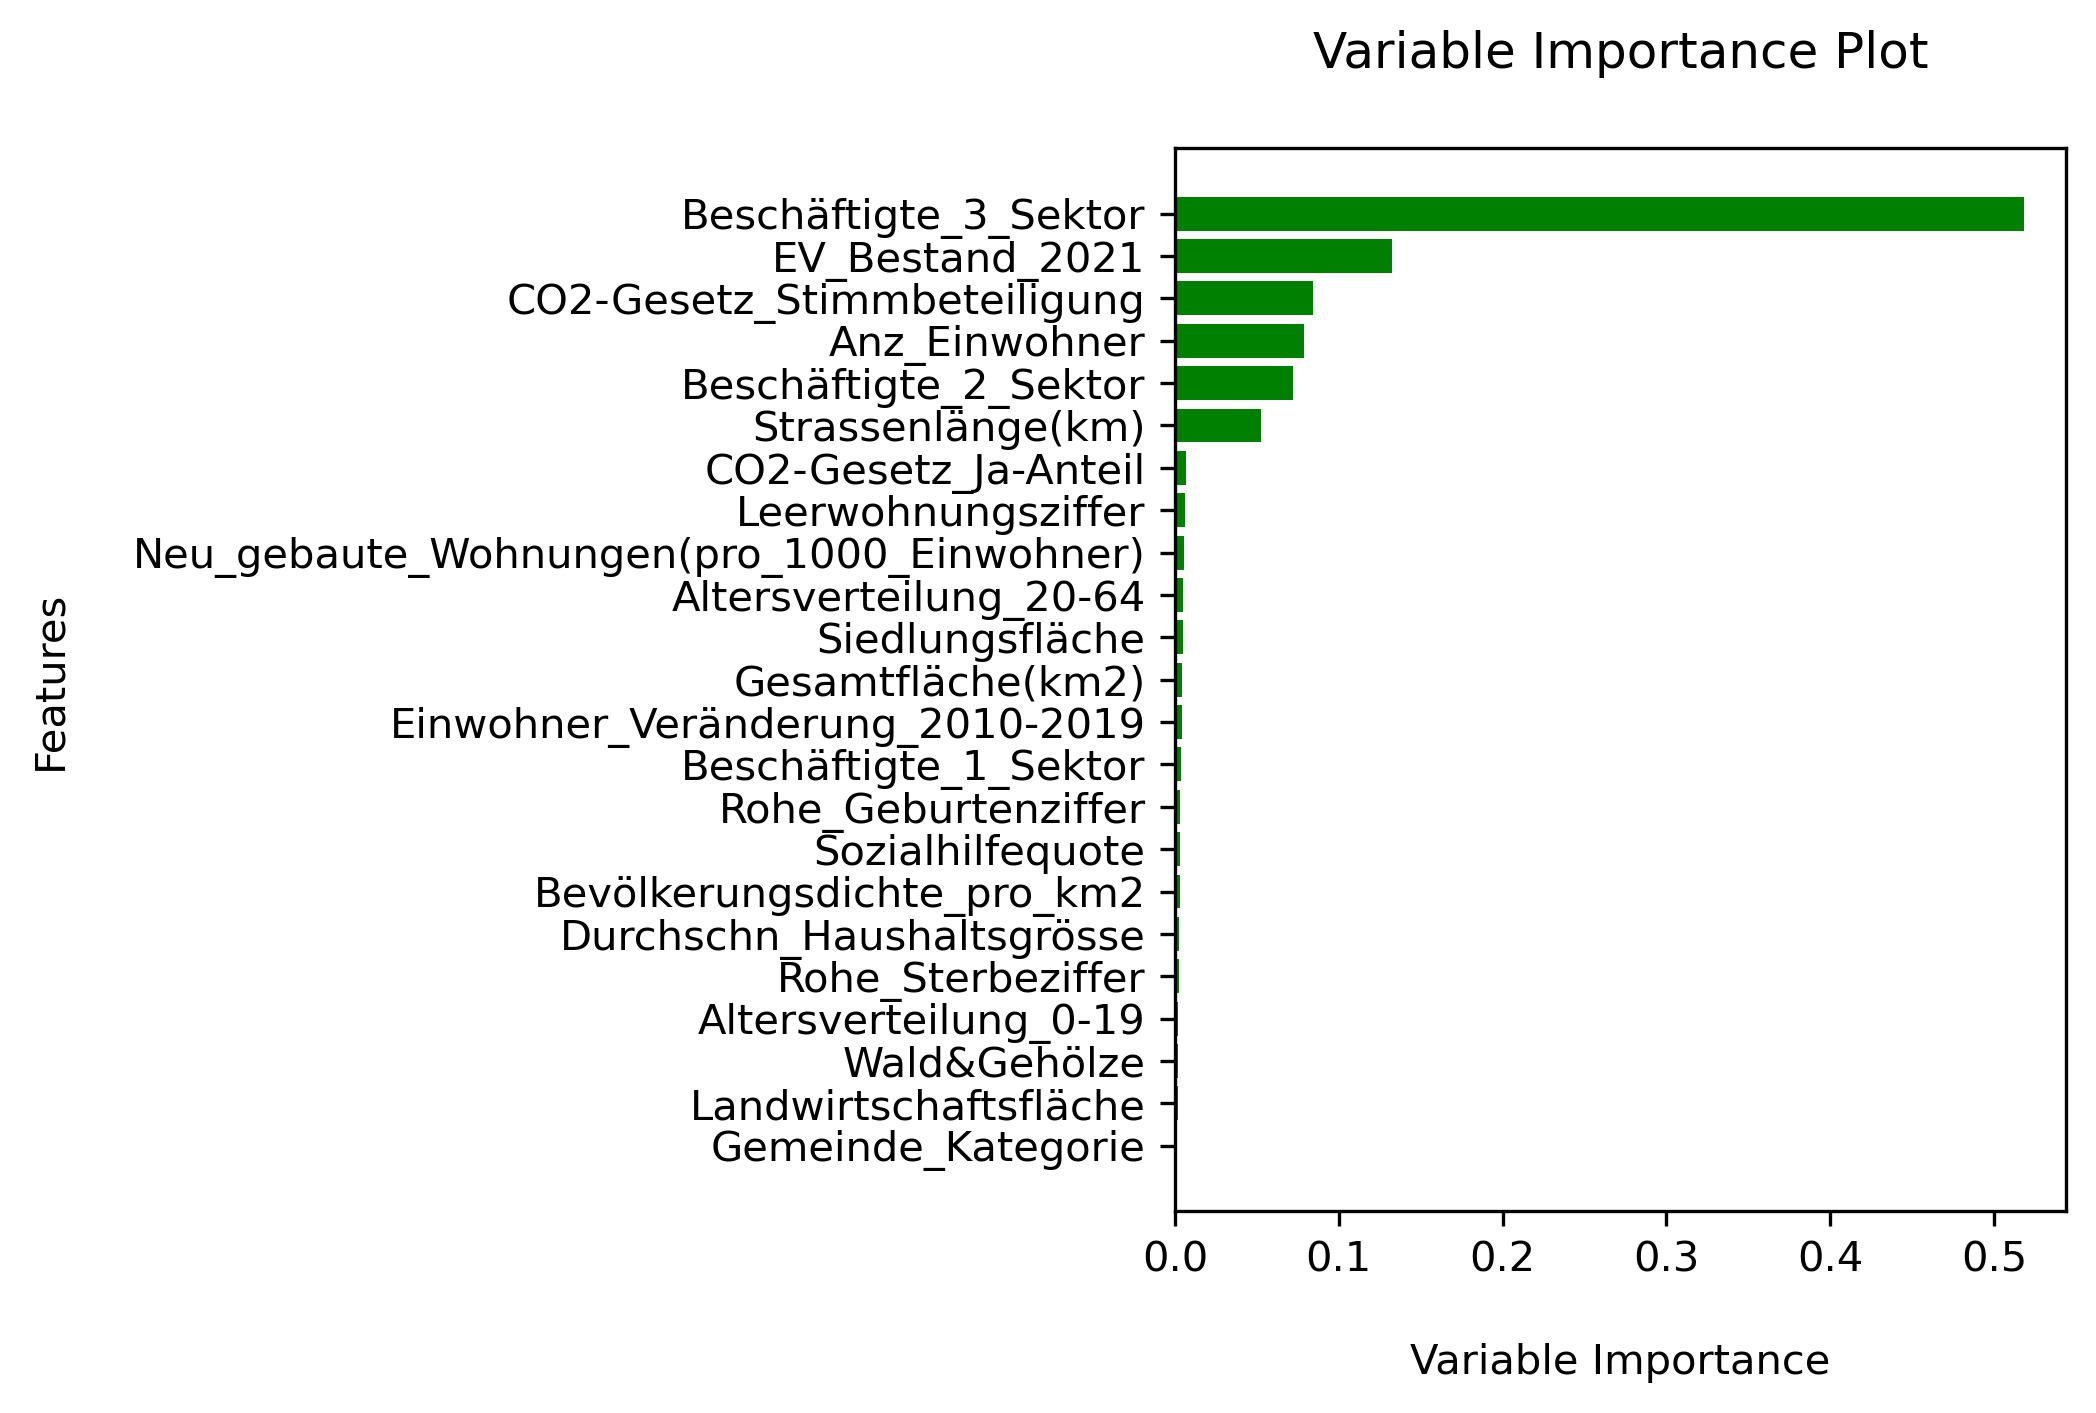

In [17]:
plot_variable_importance(forest_reg_RS, X_train)

### 5.2.2 XGBoost

In [18]:
boostparams = {
    'objective':['reg:squarederror'],
    'n_estimators': range(10, 1000, 10),
    'max_depth': range(2, 20, 2),
    'eta': [0.01, 0.02, 0.05, 0.1, 0.2],
    'subsample': [0.4, 0.5, 0.6],
    }

In [19]:
boost = XGBRegressor()
boostRS = RandomizedSearchCV(boost, boostparams).fit(X_train, y_train)

In [20]:
boostRS.best_params_

{'subsample': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 150,
 'max_depth': 12,
 'eta': 0.02}

In [21]:
y_preds = boostRS.predict(X_test).round(0)

In [22]:
print('RMSE:', mean_squared_error(y_test, y_preds, squared=False))
print('max. Error:', max_error(y_test, y_preds))
print('MAE:', mean_absolute_error(y_test, y_preds))
print('R2:', r2_score(y_test, y_preds))

RMSE: 4.28518269128335
max. Error: 52.0
MAE: 2.074418604651163
R2: 0.761127396962762


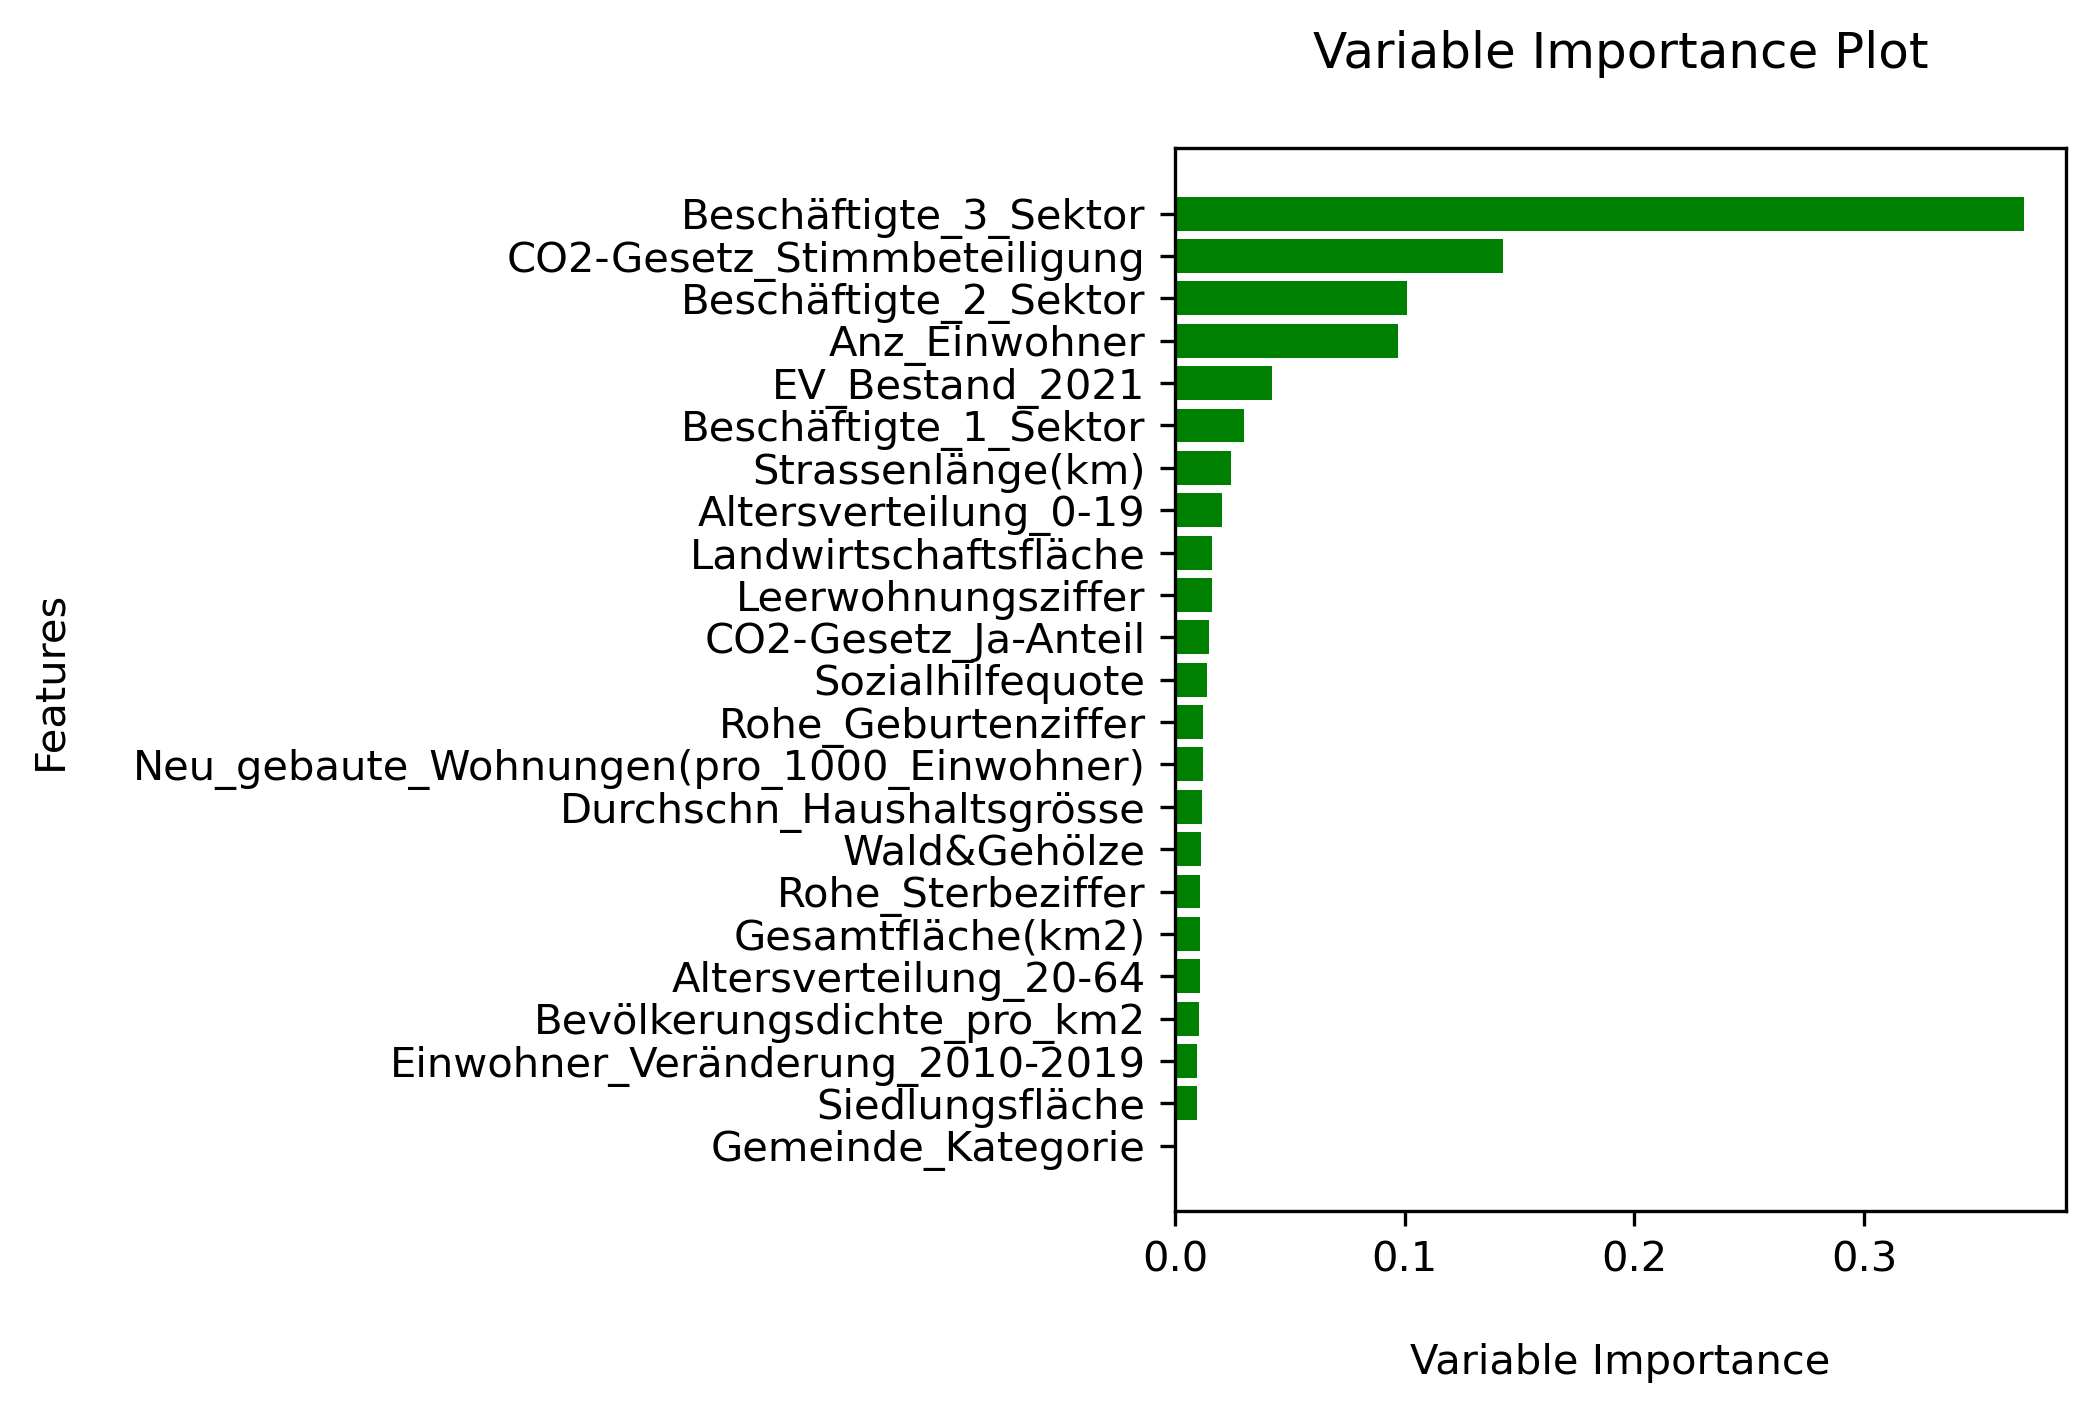

In [23]:
plot_variable_importance(boostRS, X_train)

Aufgrund der besseren Performance des XGBoost wird diese Modellarchitektur für die weiteren Schritte verwendet.

## 5.3 Modell-Training

Das vorherige Hyperparameter-Tuning diente lediglich der Auswahl des Grundmodells. Nun wird der gesamte Parameter-Raum nach der besten Kombination durchforstet.

In [24]:
XGBoostparams = {
    'objective':['reg:squarederror'],
    'n_estimators': range(130, 230, 10),
    'max_depth': range(6, 18, 2),
    'eta': [0.015, 0.02, 0.025],
    }

In [25]:
XGBoost = XGBRegressor()
XGBoost_GS = GridSearchCV(XGBoost, XGBoostparams).fit(X_train, y_train)

In [26]:
XGBoost_GS.best_params_

{'eta': 0.015,
 'max_depth': 6,
 'n_estimators': 210,
 'objective': 'reg:squarederror'}

In [27]:
y_preds = XGBoost_GS.predict(X_test).round(0)

In [28]:
print('RMSE:', mean_squared_error(y_test, y_preds, squared=False))
print('max. Error:', max_error(y_test, y_preds))
print('MAE:', mean_absolute_error(y_test, y_preds))
print('R2:', r2_score(y_test, y_preds))

RMSE: 4.192462782905355
max. Error: 36.0
MAE: 2.125581395348837
R2: 0.7713526932933834


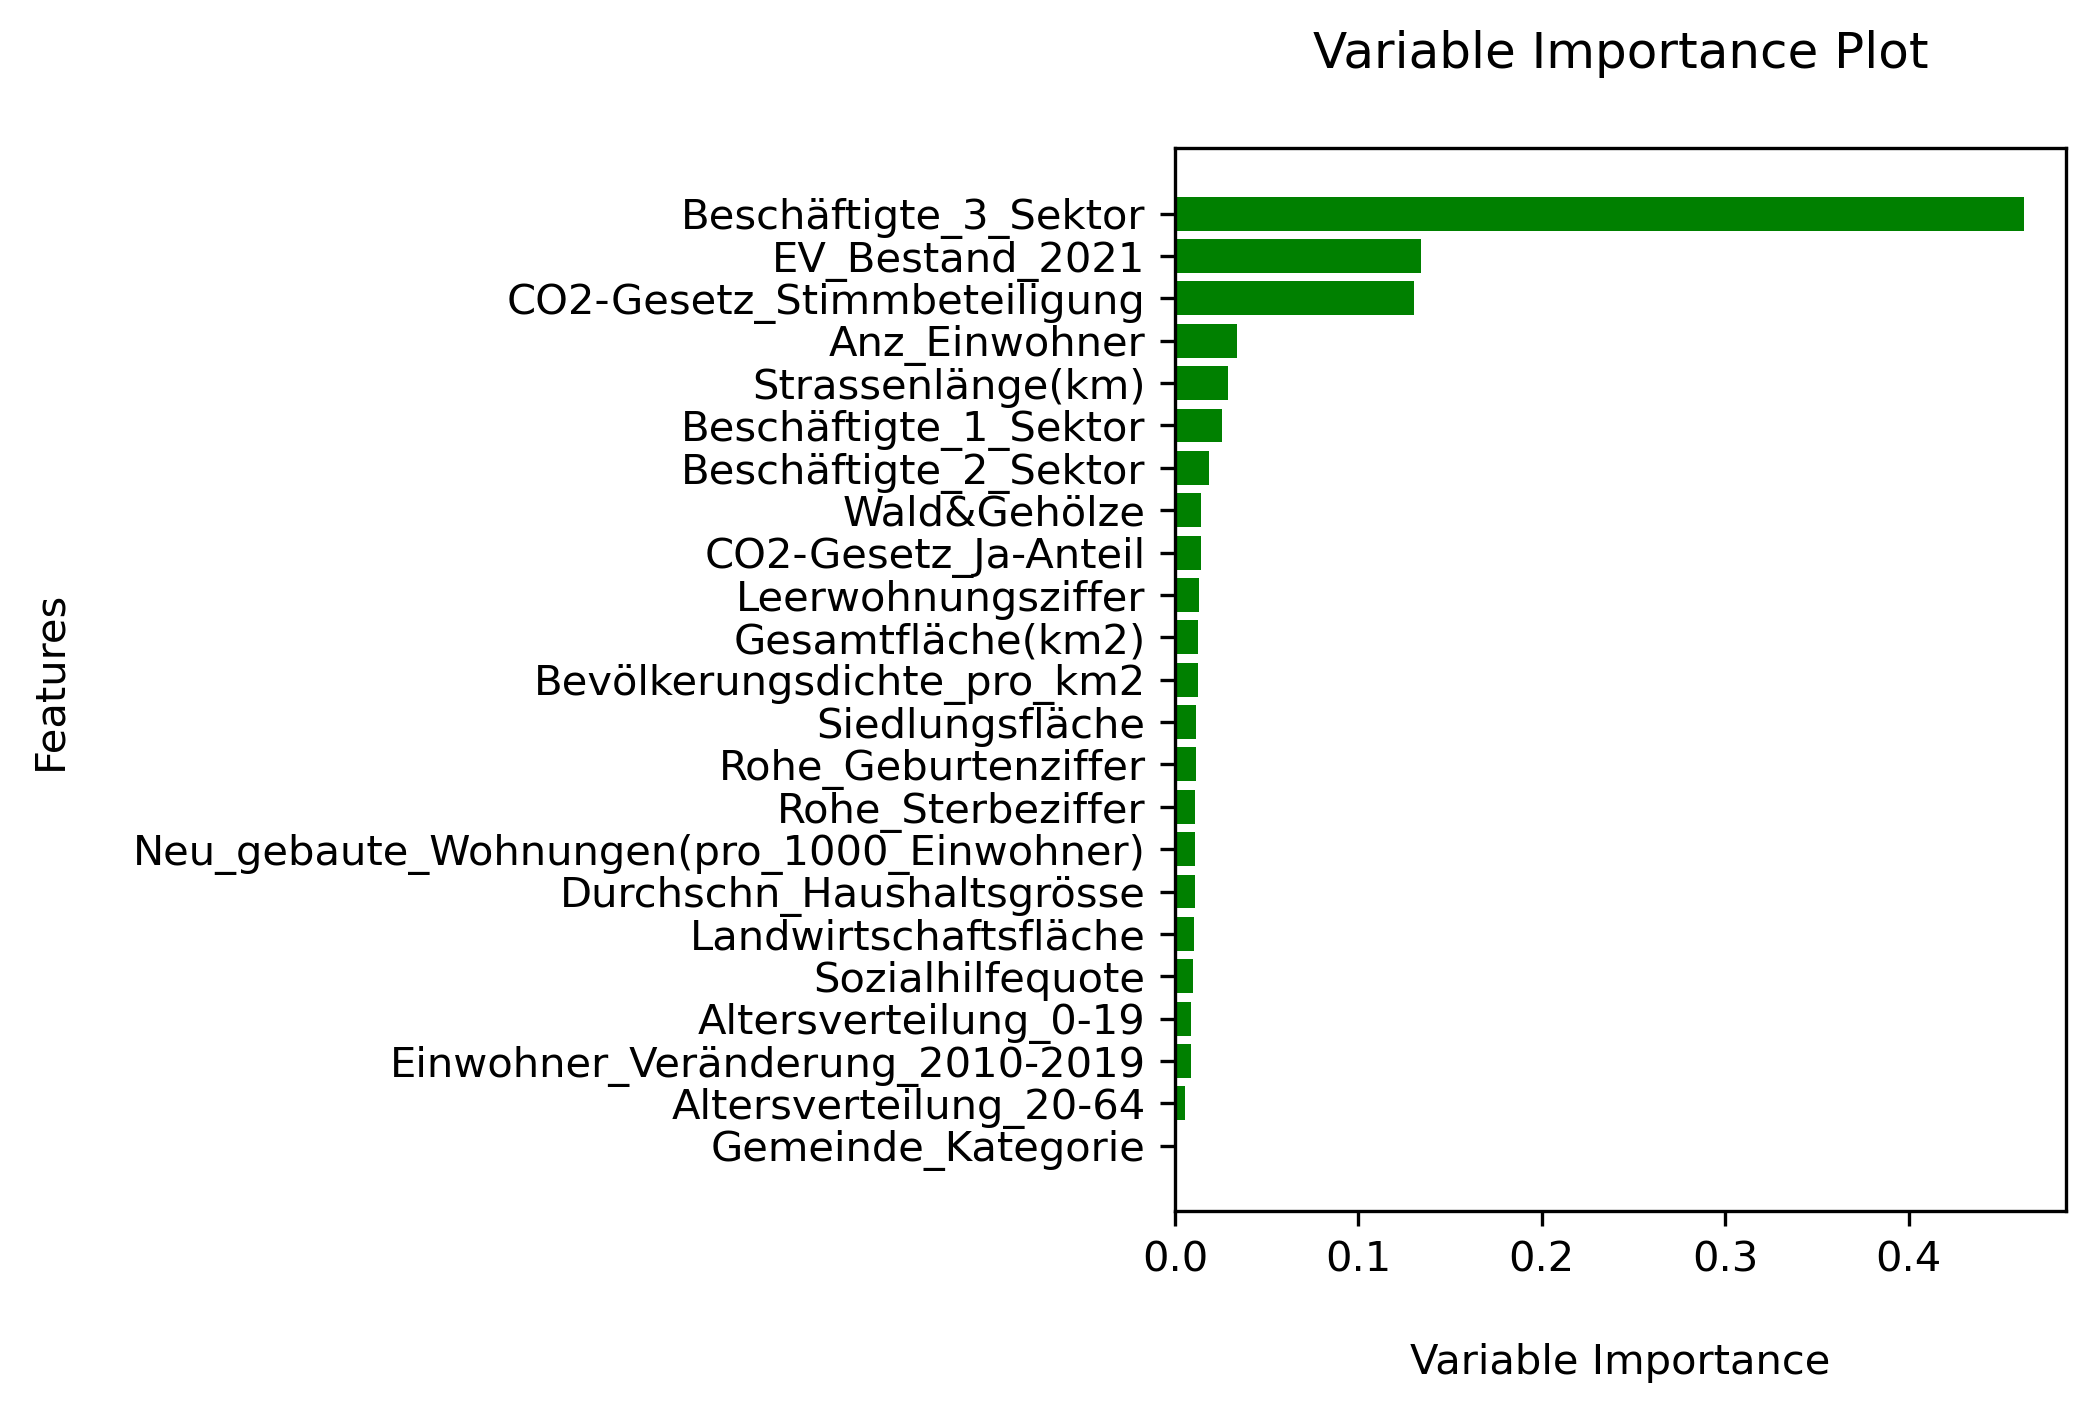

In [29]:
plot_variable_importance(XGBoost_GS, X_train)

## 5.4 Modell wird auf den gesamten DataFrame angewendet

Da wir eine optimierte Ladestation-Anzahl pro Gemeinde bestimmen möchten, wird das trainierte Modell wird nun auf den gesamten DataFrame angewendet.

In [30]:
data['aktl_Ladestationen'] = data['Ladestationen']
data.drop('Ladestationen', axis=1, inplace=True)
data.set_index('BFS-Nr', inplace=True)
data

,EV_Bestand_2021,Strassenlänge(km),Anz_Einwohner,Einwohner_Veränderung_2010-2019,Bevölkerungsdichte_pro_km2,Altersverteilung_0-19,Altersverteilung_20-64,Rohe_Geburtenziffer,Rohe_Sterbeziffer,Durchschn_Haushaltsgrösse,...,Beschäftigte_1_Sektor,Beschäftigte_2_Sektor,Beschäftigte_3_Sektor,Leerwohnungsziffer,Neu_gebaute_Wohnungen(pro_1000_Einwohner),Sozialhilfequote,CO2-Gesetz_Ja-Anteil,CO2-Gesetz_Stimmbeteiligung,Gemeinde_Kategorie,aktl_Ladestationen
BFS-Nr,,,,,,,,,,,,,,,,,,,,,
1,39.0,26.516156,1981.0,8.607456,250.442478,19.787986,62.190813,9.084027,6.560686,2.324292,...,39.0,25.0,378.0,5.291577,13.910355,1.01,53.189401,72.073343,0,1.0
2,103.0,66.711839,12303.0,10.927779,1161.756374,20.165813,61.667886,12.881135,9.212457,2.225979,...,47.0,1307.0,5566.0,1.005548,3.787255,3.02,51.250000,58.204808,1,24.0
3,70.0,31.501571,5572.0,8.005427,749.932705,23.636037,59.834889,9.892086,4.316547,2.384186,...,34.0,111.0,869.0,1.171717,0.181422,1.51,55.077960,65.184175,0,4.0
4,45.0,42.495957,3751.0,11.636905,275.808824,22.180752,59.824047,8.588298,3.757381,2.400773,...,93.0,136.0,792.0,0.630011,3.002183,1.19,50.000000,68.894099,0,0.0
5,56.0,33.142703,3778.0,10.791789,578.560490,21.625199,61.646374,7.454739,6.389776,2.378481,...,29.0,679.0,770.0,0.962696,3.248511,1.47,54.629097,69.401506,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,3.0,19.431732,559.0,1.821494,61.092896,18.425760,56.887299,16.378526,5.459509,2.315126,...,31.0,182.0,28.0,2.749141,0.000000,1.67,30.303030,61.663286,0,1.0
6807,9.0,46.657442,1238.0,-5.279265,53.732639,21.728595,52.988691,8.103728,15.397083,2.286245,...,149.0,186.0,139.0,2.155172,0.825083,2.11,32.206406,60.721868,0,0.0
6808,9.0,101.283739,1263.0,0.158604,20.453441,18.289786,56.611243,12.553943,10.984700,2.104274,...,205.0,91.0,349.0,2.422145,1.534919,2.10,45.625000,58.754513,0,0.0


Die abhängige Variabel wird von unabhängigen Variabeln getrennt

In [31]:
X = data.drop('aktl_Ladestationen', axis=1)
y = data['aktl_Ladestationen']

Die Optimierung wird erstellt:

In [32]:
predictions = XGBoost_GS.predict(X).round(0)

In [33]:
data['Ladestationen_optimiert'] = predictions
data['Differenz'] = data['Ladestationen_optimiert'] - data['aktl_Ladestationen']

Der Gemeindename wird wieder ins DataFrame eingefügt:

In [34]:
BFS = pd.read_csv(
    '00_data/BFS_Nr.csv',
    index_col=0)
BFS

,Gemeindename
BFS-Nr,
1,Aeugst am Albis
2,Affoltern am Albis
3,Bonstetten
4,Hausen am Albis
5,Hedingen
...,...
6806,Vendlincourt
6807,Basse-Allaine
6808,Clos du Doubs


In [35]:
data = data.merge(BFS, how='left', left_index=True, right_index=True)
data

,EV_Bestand_2021,Strassenlänge(km),Anz_Einwohner,Einwohner_Veränderung_2010-2019,Bevölkerungsdichte_pro_km2,Altersverteilung_0-19,Altersverteilung_20-64,Rohe_Geburtenziffer,Rohe_Sterbeziffer,Durchschn_Haushaltsgrösse,...,Leerwohnungsziffer,Neu_gebaute_Wohnungen(pro_1000_Einwohner),Sozialhilfequote,CO2-Gesetz_Ja-Anteil,CO2-Gesetz_Stimmbeteiligung,Gemeinde_Kategorie,aktl_Ladestationen,Ladestationen_optimiert,Differenz,Gemeindename
BFS-Nr,,,,,,,,,,,,,,,,,,,,,
1,39.0,26.516156,1981.0,8.607456,250.442478,19.787986,62.190813,9.084027,6.560686,2.324292,...,5.291577,13.910355,1.01,53.189401,72.073343,0,1.0,1.0,0.0,Aeugst am Albis
2,103.0,66.711839,12303.0,10.927779,1161.756374,20.165813,61.667886,12.881135,9.212457,2.225979,...,1.005548,3.787255,3.02,51.250000,58.204808,1,24.0,16.0,-8.0,Affoltern am Albis
3,70.0,31.501571,5572.0,8.005427,749.932705,23.636037,59.834889,9.892086,4.316547,2.384186,...,1.171717,0.181422,1.51,55.077960,65.184175,0,4.0,3.0,-1.0,Bonstetten
4,45.0,42.495957,3751.0,11.636905,275.808824,22.180752,59.824047,8.588298,3.757381,2.400773,...,0.630011,3.002183,1.19,50.000000,68.894099,0,0.0,2.0,2.0,Hausen am Albis
5,56.0,33.142703,3778.0,10.791789,578.560490,21.625199,61.646374,7.454739,6.389776,2.378481,...,0.962696,3.248511,1.47,54.629097,69.401506,0,0.0,2.0,2.0,Hedingen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,3.0,19.431732,559.0,1.821494,61.092896,18.425760,56.887299,16.378526,5.459509,2.315126,...,2.749141,0.000000,1.67,30.303030,61.663286,0,1.0,0.0,-1.0,Vendlincourt
6807,9.0,46.657442,1238.0,-5.279265,53.732639,21.728595,52.988691,8.103728,15.397083,2.286245,...,2.155172,0.825083,2.11,32.206406,60.721868,0,0.0,1.0,1.0,Basse-Allaine
6808,9.0,101.283739,1263.0,0.158604,20.453441,18.289786,56.611243,12.553943,10.984700,2.104274,...,2.422145,1.534919,2.10,45.625000,58.754513,0,0.0,2.0,2.0,Clos du Doubs


Für die Data App auf Streamlit werden die Daten inklusive optimierte Ladestationen und Modell exportiert:

In [36]:
# Data export
data.to_csv("final_data.csv")

In [37]:
# Model export
filename = 'finalized_model.sav'
pickle.dump(XGBoost_GS, open(filename, 'wb'))